In [164]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# need to use a gamma function later on, so import math

import math

%matplotlib inline

# create dataframe using lidar data

df = pd.read_csv(r'C:\Users\Latitude\Documents\Coursera\Wind Resource\Proj' \
                 'ect\Wind_Lidar_40and140.txt',
                sep=' ',
                header=None,
                names=['Year','Month','Day','Hour','v_40','v_140'])

In [153]:
# add in columns for velocity cibed

df['v_40_cubed'] = df['v_40']**3
df['v_140_cubed'] = df['v_140']**3

In [154]:
df.head()

,Year,Month,Day,Hour,v_40,v_140,v_40_cubed,v_140_cubed
0,2014,8,1,0.00000,3.63,5.10,47.832147,132.651000
1,2014,8,1,0.16667,3.46,5.16,41.421736,137.388096
2,2014,8,1,0.33333,3.57,5.98,45.499293,213.847192
3,2014,8,1,0.50000,3.46,5.58,41.421736,173.741112
4,2014,8,1,0.66667,3.57,4.81,45.499293,111.284641


In [155]:
# calculate mean wind speed, mean cubed wind speed, mean wind speed cubed
# use these to calculate energy patter factor, c and k

v_40_bar = df['v_40'].mean()
v_40_cubed_bar = df['v_40_cubed'].mean()
v_40_bar_cubed = v_40_bar ** 3

# energy pattern factor = epf

epf = v_40_cubed_bar / v_40_bar_cubed

# shape parameter = k

k_40 = 1 + 3.69/epf**2

# scale factor = c
# use imported math library to use gamma function math.gamma

c_40 = v_40_bar / math.gamma(1+1/k_40)

print(v_40_bar)
print(v_40_cubed_bar)
print(v_40_bar_cubed)
print (epf)
print(k_40)
print(c_40)

4.584789061797247
160.5229011033552
96.37359906594021
1.665631486829947
2.330051698138921
5.174359511210226


In [157]:
# create new dataframe from current, using bins of 0.25 and generate frequency for these
#' bins'

bins_1 = np.linspace(0,16,65,endpoint=True)
freq_df = df.apply(pd.Series.value_counts, bins=bins_1)
freq_df

,Year,Month,Day,Hour,v_40,v_140,v_40_cubed,v_140_cubed
"(-0.001, 0.25]",NaN,0,0,485,1,5,61,54
"(0.25, 0.5]",NaN,0,0,476,26,28,71,31
"(0.5, 0.75]",NaN,0,0,240,87,46,57,33
"(0.75, 1.0]",NaN,2857,1129,474,132,74,57,35
"(1.0, 1.25]",NaN,0,0,234,267,136,69,33
...,...,...,...,...,...,...,...,...
"(14.75, 15.0]",NaN,0,1031,450,1,42,58,22
"(15.0, 15.25]",NaN,0,0,227,1,36,33,30
"(15.25, 15.5]",NaN,0,0,461,1,30,101,48
"(15.5, 15.75]",NaN,0,0,224,0,27,50,21


In [158]:
# tidy up the dataframe by dropping superflous columns and adding in a % time column for 
# frequency

freq_df_tidy = freq_df.drop(['Year','Month','Day','Hour','v_40_cubed','v_140_cubed'], axis=1)
freq_df_tidy['v_40_%time'] = freq_df_tidy['v_40']/freq_df_tidy['v_40'].sum()
freq_df_tidy

,v_40,v_140,v_40_%time
"(-0.001, 0.25]",1,5,0.000030
"(0.25, 0.5]",26,28,0.000780
"(0.5, 0.75]",87,46,0.002609
"(0.75, 1.0]",132,74,0.003958
"(1.0, 1.25]",267,136,0.008006
...,...,...,...
"(14.75, 15.0]",1,42,0.000030
"(15.0, 15.25]",1,36,0.000030
"(15.25, 15.5]",1,30,0.000030
"(15.5, 15.75]",0,27,0.000000


<AxesSubplot:>

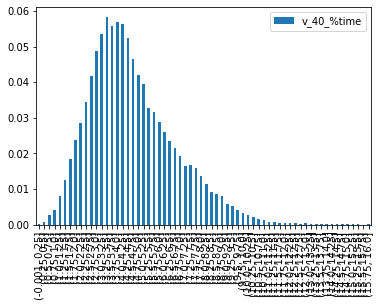

In [159]:
# check shape of frequency plot

freq_df_tidy.plot.bar(y='v_40_%time')

<BarContainer object of 64 artists>

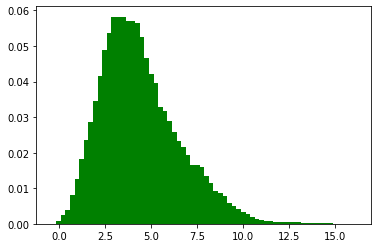

In [185]:
# use matplotlib to compare charts

plt.bar(x, freq_df_tidy['v_40_%time'], color="green")

In [160]:
#add in usable bin value for potential calculation of weibull

freq_df_tidy['windspeed_bin'] = np.linspace(0,16,64,endpoint=False)
freq_df_tidy

,v_40,v_140,v_40_%time,windspeed_bin
"(-0.001, 0.25]",1,5,0.000030,0.00
"(0.25, 0.5]",26,28,0.000780,0.25
"(0.5, 0.75]",87,46,0.002609,0.50
"(0.75, 1.0]",132,74,0.003958,0.75
"(1.0, 1.25]",267,136,0.008006,1.00
...,...,...,...,...
"(14.75, 15.0]",1,42,0.000030,14.75
"(15.0, 15.25]",1,36,0.000030,15.00
"(15.25, 15.5]",1,30,0.000030,15.25
"(15.5, 15.75]",0,27,0.000000,15.50


<BarContainer object of 64 artists>

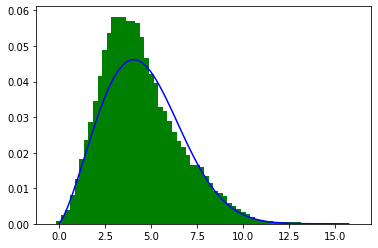

In [182]:
# plot weibull fit using k_40 and c_40 against frequency chart

x = np.linspace(0,16,64,endpoint=False)
weibull = weibull_min.pdf(x, k_40, loc=0, scale=c_40)/4
plt.plot(x, weibull, color="blue")
plt.bar(x, freq_df_tidy['v_40_%time'], color="green")

In [193]:
# calculate weibull column and wind power density from the weibull fit
# 

freq_df_tidy['Weibull_40'] = weibull_min.pdf(freq_df_tidy['windspeed_bin'], k_40, loc=0, scale=c_40)/4
freq_df_tidy['Wind_Power_Density_40'] = 0.5 * 1.225 * freq_df_tidy['Weibull_40'] * freq_df_tidy['windspeed_bin']**3

In [194]:
freq_df_tidy

,v_40,v_140,v_40_%time,windspeed_bin,Wind_Power_Density_40,Weibull_40
"(-0.001, 0.25]",1,5,0.000030,0.00,0.000000,0.000000e+00
"(0.25, 0.5]",26,28,0.000780,0.25,0.000019,1.999120e-03
"(0.5, 0.75]",87,46,0.002609,0.50,0.000383,5.008667e-03
"(0.75, 1.0]",132,74,0.003958,0.75,0.002204,8.530696e-03
"(1.0, 1.25]",267,136,0.008006,1.00,0.007580,1.237525e-02
...,...,...,...,...,...,...
"(14.75, 15.0]",1,42,0.000030,14.75,0.009191,4.676319e-06
"(15.0, 15.25]",1,36,0.000030,15.00,0.006249,3.023114e-06
"(15.25, 15.5]",1,30,0.000030,15.25,0.004200,1.933660e-06
"(15.5, 15.75]",0,27,0.000000,15.50,0.002791,1.223664e-06


In [206]:
round(freq_df_tidy['Wind_Power_Density_40'].sum(),2)

98.26

In [207]:
df['Wind_Power_Density_40'] = 0.5 * 1.225 * df['v_40']**3
round(df['Wind_Power_Density_40'].mean(),2)

98.32

In [212]:
# aim now is to optimise c_40 for weibull calculated weibull power density (98.26) to 
# equal the experimental wind power density (98.32)

from scipy.optimize import newton
from scipy import optimize

In [ ]:
# change c_40 until freq_df_tidy['Wind_Power_Density_40'].sum() = df['Wind_Power_Density_40'].mean()